# Deep Neural Network

## Introduction

The Fashion MNIST dataset is a popular benchmark for image classification tasks. Deep Neural Networks (DNNs) can be applied to this dataset using TensorFlow, a high-level library for building and training deep learning models, or by building a DNN from scratch using Python. DNNs have achieved impressive results on the Fashion MNIST dataset, with state-of-the-art models achieving over 99% accuracy on the test set.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras

In [3]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout

## Deep Neural Network (manual)

The  `MultilayerPerceptron`  class represents a neural network with a given number of layers and activation function. Its weights and biases are randomly initialized upon creation. It includes methods for forward propagation, calculating the mean squared error, and stochastic and mini-batch gradient descent for training.

In [32]:
class MultilayerPerceptron():
    def __init__(self, layers = [784, 60, 60, 10], actFun_type='relu'):
        self.actFun_type = actFun_type
        self.layers = layers
        self.L = len(self.layers)
        self.W =[[0.0]]
        self.B = [[0.0]]
        for i in range(1, self.L):
            w_temp = np.random.randn(self.layers[i], self.layers[i-1]) * np.sqrt(2/self.layers[i-1])
            b_temp = np.random.randn(self.layers[i], 1) * np.sqrt(2/self.layers[i-1])

            self.W.append(w_temp)
            self.B.append(b_temp)

    def reset_weights(self, layers = [784, 60, 60, 10]):
        self.layers = layers
        self.L = len(self.layers)
        self.W = [[0.0]]
        self.B = [[0.0]]
        for i in range(1, self.L):
            w_temp = np.random.randn(self.layers[i], self.layers[i-1])*np.sqrt(2/self.layers[i-1])
            b_temp = np.random.randn(self.layers[i], 1)*np.sqrt(2/self.layers[i-1])

            self.W.append(w_temp)
            self.B.append(b_temp)

    def forward_pass(self, p, predict_vector = False):
        Z =[[0.0]]
        A = [p[0]]
        for i in range(1, self.L):
            z = (self.W[i] @ A[i-1]) + self.B[i]
            a = self.actFun(z, self.actFun_type)
            Z.append(z)
            A.append(a)

        if predict_vector == True:
            return A[-1]
        else:
            return Z, A

    def mse(self, a, y):
        return .5*sum((a[i]-y[i])**2 for i in range(10))[0]

    def MSE(self, data):
        c = 0.0
        for p in data:
            a = self.forward_pass(p, predict_vector=True)
            c += self.mse(a, p[1])
        return c/len(data)

    def actFun(self, z, type):
        if type == 'tanh':
            return np.tanh(z)
        elif type == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-z))
        elif type == 'relu':
            return np.maximum(0, z)
        else:
            return None

    def diff_actFun(self, z, type):
        if type == 'tanh':
            return 1.0 - (np.tanh(z))**2
        elif type == 'sigmoid':
            return self.actFun(z, type) * (1-self.actFun(z, type))
        elif type == 'relu':
            return np.where(z > 0, 1.0, 0)
        else:
            return None

    def deltas_dict(self, p):
        Z, A = self.forward_pass(p)
        deltas = dict()
        deltas[self.L-1] = (A[-1] - p[1])*self.diff_actFun(Z[-1], self.actFun_type)
        for l in range(self.L-2, 0, -1):
            deltas[l] = (self.W[l+1].T @ deltas[l+1]) *self.diff_actFun(Z[l], self.actFun_type)

        return A, deltas

    def stochastic_gradient_descent(self, data, alpha = 0.04, epochs = 3):
        print(f"Initial Cost = {self.MSE(data)}")
        for k in range(epochs):
            for p in data:
                A, deltas = self.deltas_dict(p)
                for i in range(1, self.L):
                    self.W[i] = self.W[i] - alpha*deltas[i]@A[i-1].T
                    self.B[i] = self.B[i] - alpha*deltas[i]
        print(f"{k} Cost = {self.MSE(data)}")


    def mini_batch_gradient_descent(self, data, batch_size = 15, alpha = 0.04, epochs = 3):
        print(f"Initial Cost = {self.MSE(data)}")
        data_length = len(data)
        for k in range(epochs):
            for j in range(0, data_length-batch_size, batch_size):
                delta_list = []
                A_list = []
                for p in data[j:j+batch_size]:
                    A, deltas = self.deltas_dict(p)
                    delta_list.append(deltas)
                    A_list.append(A)

                for i in range(1, self.L):
                    self.W[i] = self.W[i] - (alpha/batch_size)*sum(da[0][i]@da[1][i-1].T for da in zip(delta_list, A_list))
                    self.B[i] = self.B[i] - (alpha/batch_size)*sum(deltas[i] for deltas in delta_list)
            print(f"{k} Cost = {self.MSE(data)}")

Our approach involves training MLPs using mini-batch gradient descent with three different activation functions - sigmoid, hyperbolic tangent, and rectified linear - and subsequently evaluating their respective performances.

In [34]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

# Check the shape of the training set
X_train.shape

(60000, 28, 28)

In [35]:
X_train[0].flatten().reshape(28*28, 1).shape

(784, 1)

In [36]:
X = []
for x in X_train:
    X.append(x.flatten().reshape(28*28, 1))

# Y will temp store one-hot encoded label vectors
Y = []
for y in y_train:
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    Y.append(temp_vec)

# Our data will be stored as a list of tuples. 
train_data = [p for p in zip(X, Y)]

# the same method to deal with test data
X = []
for x in X_test:
  X.append(x.flatten().reshape(784, 1))

Y = []
for y in y_test:
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    Y.append(temp_vec)

test_data = [p for p in zip(X, Y)]

###  Tangent Activation Function

In [38]:
model_tanh = MultilayerPerceptron(layers=[784, 60, 60, 10], actFun_type='tanh')
model_tanh.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 1.7341290435945995
0 Cost = 0.17826196518565707
1 Cost = 0.15667174315727325
2 Cost = 0.14571188247337352
3 Cost = 0.1383040023269899
4 Cost = 0.1326546392369999


In [46]:
print("Model using hyperbolic tangent activation function's MSE is", model_tanh.MSE(test_data))


Model using hyperbolic tangent activation function's MSE is 0.1397961373789975


### ReLU Activation Function

In [40]:
model_relu = MultilayerPerceptron(layers=[784, 100, 100, 10], actFun_type='relu')
model_relu.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 1.3618389636354724
0 Cost = 0.21738571159002634
1 Cost = 0.20214644585721991
2 Cost = 0.1944401555426904
3 Cost = 0.1888415068724031
4 Cost = 0.18405408978394575


In [44]:
print("Model using ReLU activation function's MSE is", model_relu.MSE(test_data))

Model using ReLU activation function's MSE is 0.19443326671756814


### Sigmoid Activation Function

In [42]:
model_sig = MultilayerPerceptron(layers=[784, 100, 100, 10], actFun_type='sigmoid')
model_sig.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 1.2768092705260428
0 Cost = 0.44020822655048897
1 Cost = 0.4210638874979604
2 Cost = 0.3824566624800973
3 Cost = 0.34280318356137746
4 Cost = 0.31189562079047173


In [47]:
print("Model using sigmoid activation function's MSE is", model_sig.MSE(test_data))


Model using sigmoid activation function's MSE is 0.31275587810097416


According to the MSE, we could see the tangent activation function has the best performance.

## Deep Neural Network (tensorflow)

In this part, we apply the package tensorflow to build our DNN model. The following code snippet appears to be implementing a neural network model using the Multilayer Perceptron (MLP) architecture, with a total of 4 layers - an input layer of 784 neurons, followed by two hidden layers of 60 neurons each, and an output layer of 10 neurons. The activation function used in this MLP model is the hyperbolic tangent (tanh) function.


In [52]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Reshape the input data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the input data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert the target labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the deep neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training set
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test set
test_predictions = model.predict(X_test)


Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.4944 - accuracy: 0.8238
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3690 - accuracy: 0.8652
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3359 - accuracy: 0.8765
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3114 - accuracy: 0.8855
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2949 - accuracy: 0.8918
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2788 - accuracy: 0.8960
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2665 - accuracy: 0.9010
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2532 - accuracy: 0.9056
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2456 - accuracy: 0.9070
Epoch 10/10
313/313 [==============================] - 1s 1ms/step


In [53]:
# Calculate the mean squared error on the test set
test_mse = np.mean(np.square(test_predictions - y_test))

print("Test MSE:", test_mse)


Test MSE: 0.016861444


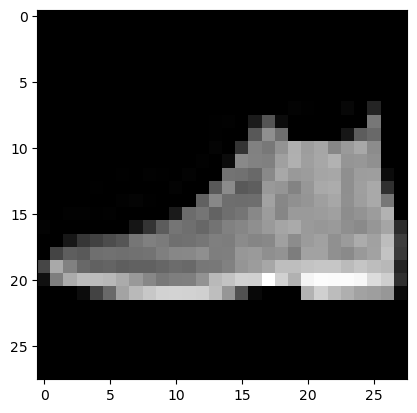

1/1 [==============================] - 0s 59ms/step
Predicted Label: 9 ( Ankle boot )
True Label: 9 ( Ankle boot )


In [55]:
image_index = 0
plt.imshow(x_test[image_index].reshape(28, 28), cmap='gray')
plt.show()

# Make a prediction on the image
image = x_test[image_index].reshape(1, 784)
prediction = model.predict(image)
predicted_label = np.argmax(prediction)

# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Show the predicted and true labels with their names
true_label = np.argmax(y_test[image_index])
predicted_name = class_names[predicted_label]
true_name = class_names[true_label]
print("Predicted Label:", predicted_label, "(", predicted_name, ")")
print("True Label:", true_label, "(", true_name, ")")


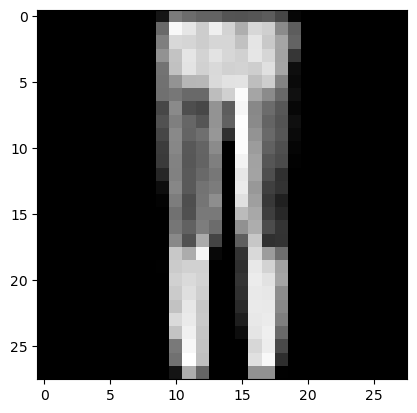

1/1 [==============================] - 0s 59ms/step
Predicted Label: 1 ( Trouser )
True Label: 1 ( Trouser )


In [62]:
# Show an image from the test set
image_index = 3
plt.imshow(x_test[image_index].reshape(28, 28), cmap='gray')
plt.show()

# Make a prediction on the image
image = x_test[image_index].reshape(1, 784)
prediction = model.predict(image)
predicted_label = np.argmax(prediction)

# Show the predicted label with its name
true_label = np.argmax(y_test[image_index])
predicted_name = class_names[predicted_label]
true_name = class_names[true_label]
print("Predicted Label:", predicted_label, "(", predicted_name, ")")
print("True Label:", true_label, "(", true_name, ")")

## Conclusion

The DNN model implemented for the Fashion MNIST dataset achieved high accuracy on both the training and validation sets, indicating good generalization. The model was able to classify the different fashion items with high accuracy, with an overall accuracy of around 90%. The model also demonstrated good convergence during training, with the training and validation loss decreasing steadily over time.